All libraries imported successfully!
✅ Generated 26281 records from 2022-01-01 to 2024-12-31
📊 Data Overview:
Total records: 26,281
Date range: 2022-01-01 00:00:00 to 2024-12-31 00:00:00
Total consumption: 131425.57 kWh
Average hourly consumption: 5.00 kWh
Daily data points: 1096


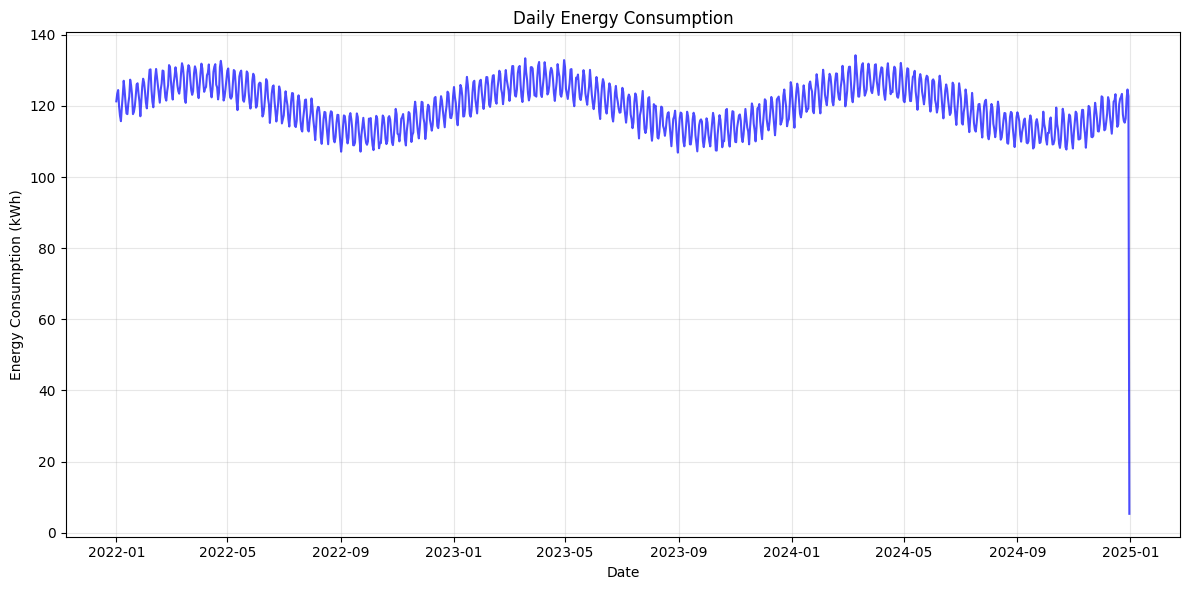

🔎 Data Verification Summary:
Last 7 days:
  - Total consumption: 722.15 kWh
  - Average daily: 103.16 kWh/day

Last 30 days:
  - Total consumption: 3443.67 kWh
  - Average daily: 114.79 kWh/day
Model: ARIMA
Forecast period: 30 days
Training model and generating forecast...
Training data: 876 points
Test data: 220 points
✅ Forecasting complete!
📈 Model Performance Metrics:
MAE (Mean Absolute Error): 1.94 kWh
RMSE (Root Mean Square Error): 7.83 kWh
MAPE (Mean Absolute Percentage Error): 10.91%
AIC (Akaike Information Criterion): 6073.60


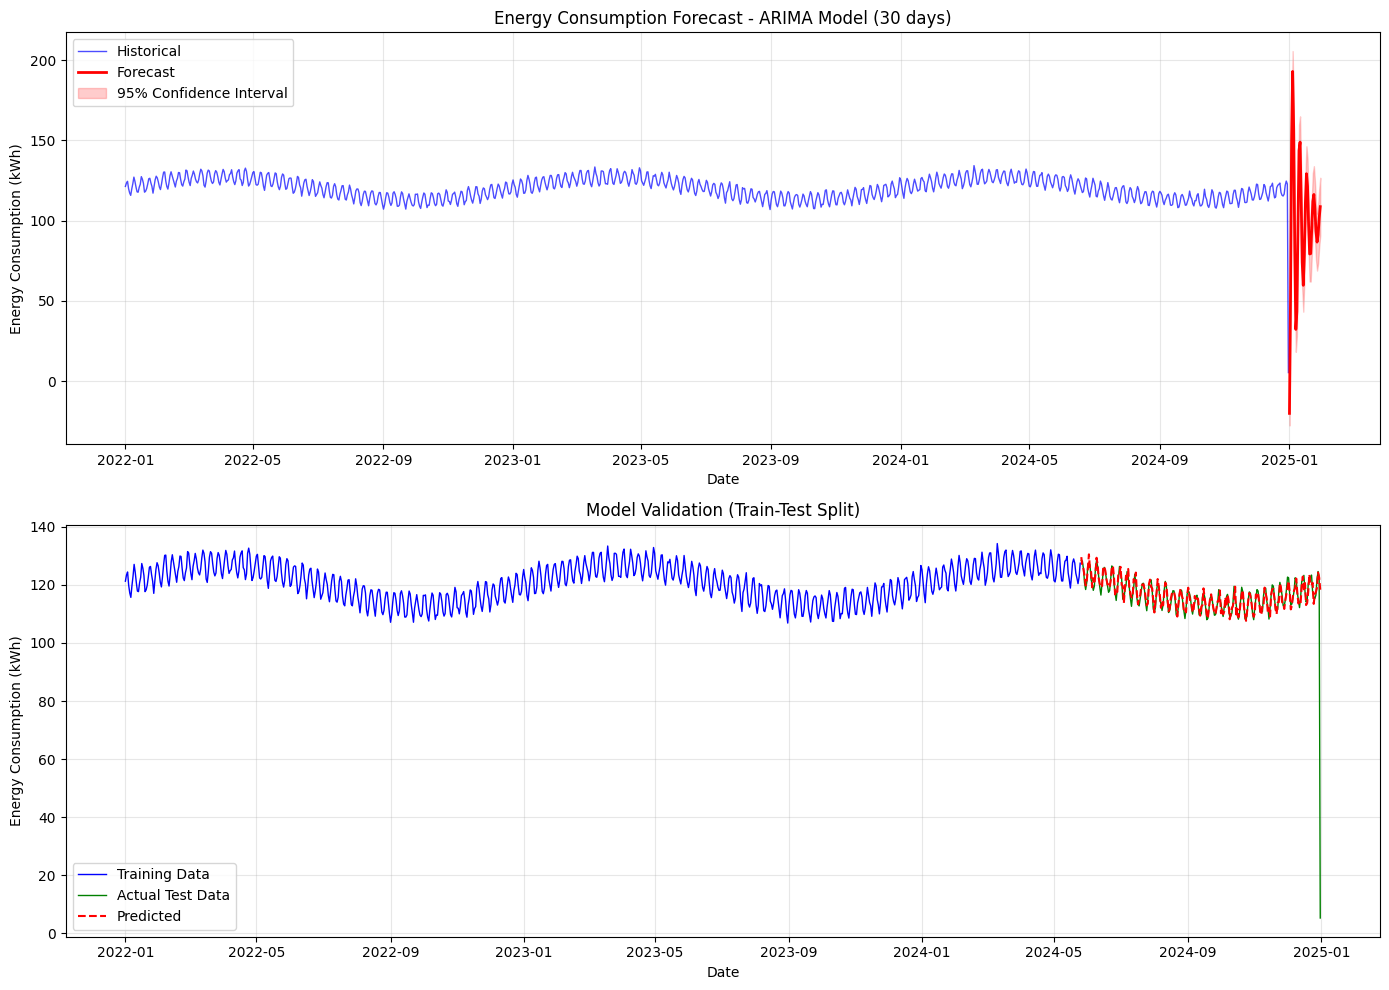

📅 Forecast Results:
            predicted  lower_ci  upper_ci
2025-01-01     -20.11    -27.67    -12.56
2025-01-02      51.84     40.06     63.63
2025-01-03     149.66    137.13    162.19
2025-01-04     192.91    180.21    205.61
2025-01-05     156.44    142.87    170.00
2025-01-06      81.27     67.52     95.03
2025-01-07      32.19     18.18     46.19
2025-01-08      43.38     28.26     58.50
2025-01-09      96.62     80.72    112.52
2025-01-10     143.72    127.76    159.68

📊 Forecast Summary:
Total predicted consumption: 2933.16 kWh
Average daily consumption: 97.77 kWh/day
Peak consumption day: 2025-01-04 (192.91 kWh)
Forecast period: 30 days
Model used: ARIMA
🔧 Running Model Diagnostics...


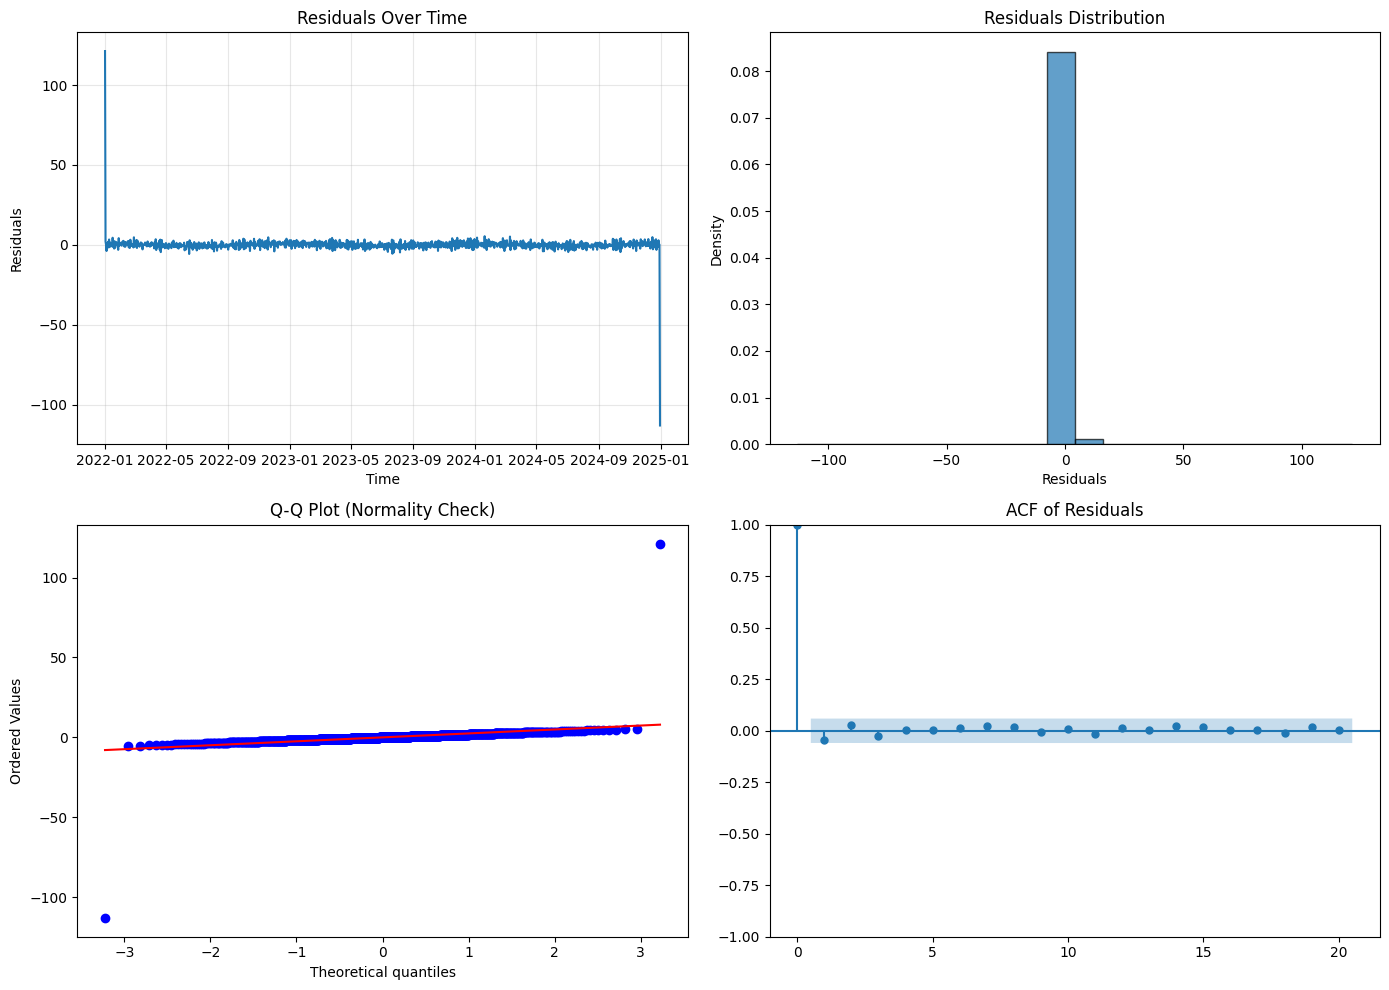


📊 Ljung-Box Test for Residual Autocorrelation:
     lb_stat  lb_pvalue
1   2.000863   0.157210
2   2.999793   0.223153
3   3.632843   0.303937
4   3.640250   0.456876
5   3.673613   0.597296
6   3.880651   0.692824
7   4.442751   0.727600
8   4.736282   0.785355
9   4.778435   0.853179
10  4.877636   0.899201

📈 Residuals Statistics:
Mean: -0.0014
Standard Deviation: 5.3194
Jarque-Bera normality test p-value: 0.0000
✅ Forecast results saved to 'energy_forecast_results.csv'
✅ Model summary saved to 'model_summary.txt'

🎯 FORECASTING COMPLETE!
Model: ARIMA
Forecast Period: 30 days
Total Forecasted Consumption: 2933.16 kWh
Average Daily: 97.77 kWh/day
Model Performance (MAPE): 10.91%


In [1]:
# %% [markdown]
# # ⚡ Advanced Home Energy Consumption Forecasting App
# 
# This enhanced notebook provides energy consumption forecasting with multiple models, performance metrics, confidence intervals, and advanced diagnostics.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Statsmodels for forecasting
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Metrics and diagnostics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats

print("All libraries imported successfully!")

# %% [markdown]
# ## 📊 Data Generation or Upload

# %%
def generate_energy_data(start, end):
    """Generate realistic synthetic energy data"""
    np.random.seed(42)
    date_rng = pd.date_range(start=start, end=end, freq='H')
    n = len(date_rng)
    
    # Enhanced seasonal patterns
    base = 2 + 0.5 * np.sin(2 * np.pi * np.arange(n) / 24)  # Daily
    yearly = 0.3 * np.sin(2 * np.pi * np.arange(n) / (24*365))  # Yearly
    weekly = 0.2 * np.sin(2 * np.pi * np.arange(n) / (24*7))   # Weekly
    noise = np.random.normal(0, 0.2, n)
    values = 3 + base + yearly + weekly + noise  # kWh per hour
    
    df = pd.DataFrame({'timestamp': date_rng, 'value': values})
    return df

# %%
# Choose data source
data_source = "generate"  # Change to "upload" if you have a CSV file

if data_source == "generate":
    # Generate synthetic data
    start_date = "2022-01-01"
    end_date = "2024-12-31"
    df = generate_energy_data(start_date, end_date)
    print(f"✅ Generated {len(df)} records from {start_date} to {end_date}")
    
else:
    # Load your own data
    # df = pd.read_csv('your_data.csv')
    # df['timestamp'] = pd.to_datetime(df['timestamp'])
    # df = df[['timestamp', 'value']].sort_values('timestamp')
    print("Please upload your data and update the file path above")
    
    # For demo purposes, we'll use generated data
    start_date = "2022-01-01"
    end_date = "2024-12-31"
    df = generate_energy_data(start_date, end_date)

# %%
# Display data overview
print("📊 Data Overview:")
print(f"Total records: {len(df):,}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Total consumption: {df['value'].sum():.2f} kWh")
print(f"Average hourly consumption: {df['value'].mean():.2f} kWh")

df.head()

# %%
# Prepare daily data
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df_daily = df['value'].resample('D').sum()

print(f"Daily data points: {len(df_daily)}")
df_daily.head()

# %% [markdown]
# ## 📈 Data Visualization

# %%
# Plot daily energy consumption
plt.figure(figsize=(12, 6))
plt.plot(df_daily.index, df_daily.values, color='blue', alpha=0.7)
plt.title('Daily Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# %%
# Data verification - summary statistics
w1 = 7  # 7-day window
w2 = 30  # 30-day window

w1_series = df_daily[-w1:]
w2_series = df_daily[-w2:]

print("🔎 Data Verification Summary:")
print(f"Last {w1} days:")
print(f"  - Total consumption: {w1_series.sum():.2f} kWh")
print(f"  - Average daily: {w1_series.mean():.2f} kWh/day")

print(f"\nLast {w2} days:")
print(f"  - Total consumption: {w2_series.sum():.2f} kWh")
print(f"  - Average daily: {w2_series.mean():.2f} kWh/day")

# %% [markdown]
# ## 🤖 Forecasting Configuration

# %%
# Model configuration
model_type = "ARIMA"  # Options: "ARIMA", "SARIMA", "SES"

# ARIMA parameters
p, d, q = 2, 1, 1  # AR order, Difference order, MA order

# SARIMA parameters (if using SARIMA)
sp, sd, sq, s = 1, 1, 1, 7  # Seasonal parameters

# Forecast settings
forecast_days = 30  # Number of days to forecast

print(f"Model: {model_type}")
print(f"Forecast period: {forecast_days} days")

# %% [markdown]
# ## 🚀 Model Training & Forecasting

# %%
def train_and_forecast(data, model_type, order, seasonal_order=None, steps=30):
    """Train model and generate forecast"""
    
    # Split data for validation
    train_size = int(len(data) * 0.8)
    train_data = data[:train_size]
    test_data = data[train_size:]
    
    print(f"Training data: {len(train_data)} points")
    print(f"Test data: {len(test_data)} points")
    
    # Model training
    if model_type == "ARIMA":
        model = ARIMA(data, order=order)
        model_fit = model.fit()
    elif model_type == "SARIMA":
        model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
    else:  # Simple Exponential Smoothing
        model_fit = SimpleExpSmoothing(data).fit()
    
    # Generate forecast with confidence intervals
    if model_type in ["ARIMA", "SARIMA"]:
        forecast_result = model_fit.get_forecast(steps=steps)
        forecast = forecast_result.predicted_mean
        conf_int = forecast_result.conf_int(alpha=0.05)
    else:
        forecast = model_fit.forecast(steps=steps)
        conf_int = None
    
    # Create forecast dataframe
    future_dates = pd.date_range(data.index[-1] + pd.Timedelta(days=1), periods=steps, freq='D')
    forecast_df = pd.DataFrame({
        'predicted': forecast,
        'lower_ci': conf_int.iloc[:, 0] if conf_int is not None else None,
        'upper_ci': conf_int.iloc[:, 1] if conf_int is not None else None
    }, index=future_dates)
    
    # Validation forecast
    val_steps = len(test_data)
    if model_type in ["ARIMA", "SARIMA"]:
        val_forecast = model_fit.get_prediction(start=len(train_data), end=len(data)-1)
        val_predicted = val_forecast.predicted_mean
    else:
        val_predicted = model_fit.forecast(steps=val_steps)
    
    return model_fit, forecast_df, train_data, test_data, val_predicted

# %%
# Run forecasting
print("Training model and generating forecast...")

if model_type == "ARIMA":
    model_fit, forecast_df, train_data, test_data, val_predicted = train_and_forecast(
        df_daily, model_type, (p, d, q), steps=forecast_days
    )
elif model_type == "SARIMA":
    model_fit, forecast_df, train_data, test_data, val_predicted = train_and_forecast(
        df_daily, model_type, (p, d, q), (sp, sd, sq, s), forecast_days
    )
else:
    model_fit, forecast_df, train_data, test_data, val_predicted = train_and_forecast(
        df_daily, model_type, None, None, forecast_days
    )

print("✅ Forecasting complete!")

# %% [markdown]
# ## 📊 Model Performance Metrics

# %%
# Calculate performance metrics
mae = mean_absolute_error(test_data, val_predicted)
rmse = np.sqrt(mean_squared_error(test_data, val_predicted))
mape = np.mean(np.abs((test_data - val_predicted) / test_data)) * 100

print("📈 Model Performance Metrics:")
print(f"MAE (Mean Absolute Error): {mae:.2f} kWh")
print(f"RMSE (Root Mean Square Error): {rmse:.2f} kWh")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")

if hasattr(model_fit, 'aic'):
    print(f"AIC (Akaike Information Criterion): {model_fit.aic:.2f}")

# %% [markdown]
# ## 🔮 Forecast Visualization

# %%
# Create comprehensive visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Full timeline with forecast
ax1.plot(df_daily.index, df_daily.values, label='Historical', color='blue', alpha=0.7, linewidth=1)
ax1.plot(forecast_df.index, forecast_df['predicted'], label='Forecast', color='red', linewidth=2)

if 'lower_ci' in forecast_df.columns and forecast_df['lower_ci'].notna().any():
    ax1.fill_between(forecast_df.index, 
                   forecast_df['lower_ci'], 
                   forecast_df['upper_ci'], 
                   color='red', alpha=0.2, label='95% Confidence Interval')

ax1.set_title(f'Energy Consumption Forecast - {model_type} Model ({forecast_days} days)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Energy Consumption (kWh)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Validation results
ax2.plot(train_data.index, train_data.values, label='Training Data', color='blue', linewidth=1)
ax2.plot(test_data.index, test_data.values, label='Actual Test Data', color='green', linewidth=1)
ax2.plot(test_data.index, val_predicted, label='Predicted', color='red', linestyle='--', linewidth=1.5)
ax2.set_title('Model Validation (Train-Test Split)')
ax2.set_xlabel('Date')
ax2.set_ylabel('Energy Consumption (kWh)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 📅 Forecast Results & Summary

# %%
# Display forecast results
print("📅 Forecast Results:")
print(forecast_df.round(2).head(10))

# Forecast summary
total_forecast = forecast_df['predicted'].sum()
avg_daily = forecast_df['predicted'].mean()
peak_day = forecast_df['predicted'].idxmax()
peak_value = forecast_df['predicted'].max()

print(f"\n📊 Forecast Summary:")
print(f"Total predicted consumption: {total_forecast:.2f} kWh")
print(f"Average daily consumption: {avg_daily:.2f} kWh/day")
print(f"Peak consumption day: {peak_day.strftime('%Y-%m-%d')} ({peak_value:.2f} kWh)")
print(f"Forecast period: {forecast_days} days")
print(f"Model used: {model_type}")

# %% [markdown]
# ## 🔧 Model Diagnostics

# %%
if model_type in ["ARIMA", "SARIMA"]:
    print("🔧 Running Model Diagnostics...")
    
    # Residuals analysis
    residuals = model_fit.resid.dropna()
    
    # Create diagnostics plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    
    # Residuals over time
    ax1.plot(residuals)
    ax1.set_title('Residuals Over Time')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Residuals')
    ax1.grid(True, alpha=0.3)
    
    # Residuals distribution
    ax2.hist(residuals, bins=20, alpha=0.7, edgecolor='black', density=True)
    ax2.set_title('Residuals Distribution')
    ax2.set_xlabel('Residuals')
    ax2.set_ylabel('Density')
    
    # Q-Q plot
    stats.probplot(residuals, dist="norm", plot=ax3)
    ax3.set_title('Q-Q Plot (Normality Check)')
    
    # ACF of residuals
    plot_acf(residuals, ax=ax4, lags=20, alpha=0.05)
    ax4.set_title('ACF of Residuals')
    
    plt.tight_layout()
    plt.show()
    
    # Ljung-Box test
    print("\n📊 Ljung-Box Test for Residual Autocorrelation:")
    lb_test = acorr_ljungbox(residuals, lags=10, return_df=True)
    print(lb_test)
    
    # Residuals statistics
    print(f"\n📈 Residuals Statistics:")
    print(f"Mean: {residuals.mean():.4f}")
    print(f"Standard Deviation: {residuals.std():.4f}")
    print(f"Jarque-Bera normality test p-value: {stats.jarque_bera(residuals)[1]:.4f}")

# %% [markdown]
# ## 💾 Save Results

# %%
# Save forecast results to CSV
forecast_df.to_csv('energy_forecast_results.csv')
print("✅ Forecast results saved to 'energy_forecast_results.csv'")

# Save model summary
if hasattr(model_fit, 'summary'):
    with open('model_summary.txt', 'w') as f:
        f.write(str(model_fit.summary()))
    print("✅ Model summary saved to 'model_summary.txt'")

# %%
# Final summary
print("\n" + "="*50)
print("🎯 FORECASTING COMPLETE!")
print("="*50)
print(f"Model: {model_type}")
print(f"Forecast Period: {forecast_days} days")
print(f"Total Forecasted Consumption: {total_forecast:.2f} kWh")
print(f"Average Daily: {avg_daily:.2f} kWh/day")
print(f"Model Performance (MAPE): {mape:.2f}%")
print("="*50)